In [37]:
# Java + PySpark
!apt-get -qq install -y openjdk-11-jdk
!pip -q install pyspark==3.5.1
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.2 MB/s eta 0:00:00


In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

from pyspark.sql import SparkSession, functions as F, types as T

# Start Spark
spark = (SparkSession.builder
         .appName("Location-BigData-Analysis")
         .config("spark.sql.execution.arrow.pyspark.enabled", "true")
         .getOrCreate())

In [2]:
# import libraries
from pyspark.sql import functions as F, types as T
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
print("Spark version:", spark.version)

Spark version: 3.5.1


## Read Dataset

In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/directory.csv'

In [6]:
# If your file is TSV or has a different delimiter, set sep="\t" etc.
df_raw = (spark.read
          .option("header", True)
          .option("inferSchema", True)
          .option("multiLine", True)    # just in case
          .option("escape", '"')
          .csv(file_path))

print("Row count (raw):", df_raw.count())
df_raw.printSchema()
df_raw.show(10, truncate=False)

Row count (raw): 25600
root
 |-- Brand: string (nullable = true)
 |-- Store Number: string (nullable = true)
 |-- Store Name: string (nullable = true)
 |-- Ownership Type: string (nullable = true)
 |-- Street Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Phone Number: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)

+---------+------------+------------------------+--------------+-------------------------------+----------------+--------------+-------+--------+------------+-----------------------+---------+--------+
|Brand    |Store Number|Store Name              |Ownership Type|Street Address                 |City            |State/Province|Country|Postcode|Phone Number|Timezone               |Longitude|Latitude|
+---------+------------+--

## Convert CSV to Parquet

In [7]:
PARQUET_PATH = "/content/drive/MyDrive/Colab Notebooks/Dataset/directory-parquet"
(df_raw
 .repartition(8)     # adjust based on size; more partitions for larger data
 .write
 .mode("overwrite")
 .parquet(PARQUET_PATH))

## Read Parquet File

In [8]:
# Re-read as Parquet (much faster & smaller)
df = spark.read.parquet(PARQUET_PATH)
df.cache()
print("Row count (parquet):", df.count())

Row count (parquet): 25600


## EDA

In [9]:
df.show(10, truncate=True)

+---------+------------+--------------------+--------------+---------------------------------+-----------------+--------------+-------+---------+-------------+--------------------+---------+--------+
|    Brand|Store Number|          Store Name|Ownership Type|                   Street Address|             City|State/Province|Country| Postcode| Phone Number|            Timezone|Longitude|Latitude|
+---------+------------+--------------------+--------------+---------------------------------+-----------------+--------------+-------+---------+-------------+--------------------+---------+--------+
|Starbucks|  5895-31839|Folsom & Julliard...| Company Owned|                8393 Folsom Blvd.|       Sacramento|            CA|     US|958263546| 916-381-3498|GMT-08:00 America...|  -121.39|   38.55|
|Starbucks|22591-221947|Kroger - Suffolk ...|      Licensed|             1017 University Blvd|          Suffolk|            VA|     US|    23435| 757-335-4536|GMT-05:00 America...|   -76.09|    36.8|


In [10]:
# ---------- Basic shape & schema ----------
row_count = df.count()
cols = df.columns
print(f"Rows: {row_count:,} | Columns: {len(cols)}")
df.printSchema()

Rows: 25,600 | Columns: 13
root
 |-- Brand: string (nullable = true)
 |-- Store Number: string (nullable = true)
 |-- Store Name: string (nullable = true)
 |-- Ownership Type: string (nullable = true)
 |-- Street Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Phone Number: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)



In [11]:
# ---------- Column type buckets ----------
def split_cols_by_type(df):
    numeric_types = (T.ByteType, T.ShortType, T.IntegerType, T.LongType,
                     T.FloatType, T.DoubleType, T.DecimalType)
    date_types = (T.DateType, T.TimestampType)
    num_cols, cat_cols, date_cols = [], [], []
    for f in df.schema.fields:
        if isinstance(f.dataType, numeric_types):
            num_cols.append(f.name)
        elif isinstance(f.dataType, date_types):
            date_cols.append(f.name)
        else:
            cat_cols.append(f.name)
    return num_cols, cat_cols, date_cols

num_cols, cat_cols, date_cols = split_cols_by_type(df)
print("Numeric:", num_cols)
print("Categorical/Text:", cat_cols)
print("Date/Time:", date_cols)

Numeric: ['Longitude', 'Latitude']
Categorical/Text: ['Brand', 'Store Number', 'Store Name', 'Ownership Type', 'Street Address', 'City', 'State/Province', 'Country', 'Postcode', 'Phone Number', 'Timezone']
Date/Time: []


In [12]:
# Counts of NULLs per column (for strings, also treat empty "" as missing-ish)
missing_exprs = []
for c in cols:
    is_null = F.col(c).isNull()
    if c in cat_cols:
        is_null = is_null | (F.trim(F.col(c)) == "")
    missing_exprs.append(F.sum(F.when(is_null, 1).otherwise(0)).alias(c))

na_counts = df.agg(*missing_exprs)
print("Null/empty counts per column:")
na_counts.show(truncate=False)

Null/empty counts per column:
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|Brand|Store Number|Store Name|Ownership Type|Street Address|City|State/Province|Country|Postcode|Phone Number|Timezone|Longitude|Latitude|
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|0    |0           |0         |0             |2             |14  |0             |0      |1521    |6861        |0       |1        |1       |
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+



In [13]:
# Rows containing ANY missing value:
any_na_count = df.where(
    F.greatest(*[F.when(F.col(c).isNull(), 1).otherwise(0) for c in cols]) == 1
).count()
print("Rows with at least one missing value:", any_na_count)

Rows with at least one missing value: 7515


In [14]:
# ---------- Cardinality & distincts ----------
distinct_exprs = [F.countDistinct(F.col(c)).alias(c) for c in cols]
distinct_counts = df.agg(*distinct_exprs)
print("Distinct counts per column:")
distinct_counts.show(truncate=False)

Distinct counts per column:
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|Brand|Store Number|Store Name|Ownership Type|Street Address|City|State/Province|Country|Postcode|Phone Number|Timezone|Longitude|Latitude|
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|4    |25599       |25364     |4             |25353         |5470|338           |73     |18888   |18559       |101     |6834     |3770    |
+-----+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+



In [15]:
# Only compute for low-cardinality columns to keep it scalable.
MAX_CARDINALITY = 50
card_map = (df.agg(*[F.countDistinct(c).alias(c) for c in cat_cols])
            .collect()[0].asDict()) if cat_cols else {}

for c in cat_cols:
    if card_map.get(c, 1e9) <= MAX_CARDINALITY:
        print(f"Top frequencies for {c}:")
        (df.groupBy(c).count()
           .orderBy(F.desc("count"))
           .show(50, truncate=False))  # safe upper bound for display

Top frequencies for Brand:
+---------------------+-----+
|Brand                |count|
+---------------------+-----+
|Starbucks            |25249|
|Teavana              |348  |
|Evolution Fresh      |2    |
|Coffee House Holdings|1    |
+---------------------+-----+

Top frequencies for Ownership Type:
+--------------+-----+
|Ownership Type|count|
+--------------+-----+
|Company Owned |11932|
|Licensed      |9375 |
|Joint Venture |3976 |
|Franchise     |317  |
+--------------+-----+



In [16]:
# Numeric summary
if num_cols:
    print("Numeric summary (count, mean, stddev, min, 25%, 50%, 75%, max):")
    df.select(*num_cols).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)


Numeric summary (count, mean, stddev, min, 25%, 50%, 75%, max):
+-------+-------------------+------------------+
|summary|Longitude          |Latitude          |
+-------+-------------------+------------------+
|count  |25599              |25599             |
|mean   |-27.872234462283604|34.79301574280246 |
|stddev |96.84404572163066  |13.342332449375183|
|min    |-159.46            |-46.41            |
|25%    |-104.67            |31.24             |
|50%    |-79.36             |36.75             |
|75%    |100.62             |41.57             |
|max    |176.92             |64.85             |
+-------+-------------------+------------------+



In [17]:
# Duplicate rows
dup_count = (df.groupBy(*cols).count().filter(F.col("count") > 1).count()
             if cols else 0)
print("Duplicate rows (full-row duplicates):", dup_count)

Duplicate rows (full-row duplicates): 0


### Outlines Check - IQR

In [18]:
def split_cols_by_type(df):
    numeric_types = (T.ByteType, T.ShortType, T.IntegerType, T.LongType,
                     T.FloatType, T.DoubleType, T.DecimalType)
    num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, numeric_types)]
    return num_cols

def detect_outliers_iqr(df, rel_err=0.01):
    """
    Returns a Spark DataFrame with: column, Q1, Q3, IQR, lower_bound, upper_bound,
    low_count, high_count for each numeric column in df.
    rel_err: relative error for approxQuantile (0.01 = 1% error)
    """
    num_cols = split_cols_by_type(df)
    results = []
    for c in num_cols:
        q1, q3 = df.approxQuantile(c, [0.25, 0.75], rel_err)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        low_count = df.filter(F.col(c) < lower).count()
        high_count = df.filter(F.col(c) > upper).count()
        results.append((c, q1, q3, iqr, lower, upper, low_count, high_count))

    schema = T.StructType([
        T.StructField("column", T.StringType()),
        T.StructField("Q1", T.DoubleType()),
        T.StructField("Q3", T.DoubleType()),
        T.StructField("IQR", T.DoubleType()),
        T.StructField("lower_bound", T.DoubleType()),
        T.StructField("upper_bound", T.DoubleType()),
        T.StructField("low_count", T.LongType()),
        T.StructField("high_count", T.LongType())
    ])

    return spark.createDataFrame(results, schema)

# --- Run detection ---
outlier_stats_df = detect_outliers_iqr(df)
outlier_stats_df.show(truncate=False)


+---------+-------+------+------------------+------------------+------------------+---------+----------+
|column   |Q1     |Q3    |IQR               |lower_bound       |upper_bound       |low_count|high_count|
+---------+-------+------+------------------+------------------+------------------+---------+----------+
|Longitude|-103.38|100.37|203.75            |-409.005          |405.995           |0        |0         |
|Latitude |31.26  |41.27 |10.010000000000002|16.244999999999997|56.285000000000004|1740     |136       |
+---------+-------+------+------------------+------------------+------------------+---------+----------+



#  Preprocessing

In [19]:
# Based on the EDA results, here are some preprocessing techniques you could consider:

# 1. Handling Missing Values:
#    - 'Postcode', 'Phone Number', 'Longitude', 'Latitude' and 'City' have missing values.
#    - Depending on the analysis, you could:
#      - Drop rows with missing 'Longitude' or 'Latitude' if geographical analysis is key. (Already done for mapping)
#      - Impute missing 'City' based on 'State/Province' and 'Country' if possible, or treat as a separate category.
#      - Decide how to handle missing 'Postcode' and 'Phone Number' based on their relevance to the task (e.g., impute with a placeholder, drop the column if not needed).

# 2. Handling Outliers:
#    - The IQR analysis showed a significant number of potential outliers in 'Latitude'.
#    - You could investigate these outliers to see if they are valid data points or errors.
#    - Depending on the nature of the analysis, you might:
#      - Cap or clip the values (replace outliers with the upper/lower bound).
#      - Transform the data (e.g., log transformation) if the distribution is skewed.
#      - Use robust statistical methods that are less sensitive to outliers.

# 3. Feature Engineering:
#    - Create new features from existing ones:
#      - Combine 'Street Address', 'City', 'State/Province', 'Country', and 'Postcode' into a full address string.
#      - Extract information from 'Timezone' (e.g., GMT offset).

# 4. Data Type Conversion:
#    - Ensure columns have appropriate data types for your analysis (Spark's `inferSchema` did a good job, but it's always good to confirm).

# 5. Categorical Feature Encoding:
#    - If you plan to use machine learning models, you'll need to encode categorical columns ('Brand', 'Ownership Type', 'Country', 'State/Province', etc.) using techniques like One-Hot Encoding or Label Encoding.

# The specific techniques you choose will depend on the goals of your analysis.

In [20]:
# Filter the DataFrame to keep only Starbucks
df_starbucks = df.filter(df.Brand == "Starbucks")

# Drop the 'Brand' column as it's now redundant
df_starbucks_only = df_starbucks.drop("Brand")

# Show the first few rows of the new DataFrame
print("Starbucks locations (Brand column dropped):")
df_starbucks_only.show(10, truncate=False)

# Print the count of the new DataFrame
print("Row count (Starbucks only):", df_starbucks_only.count())

Starbucks locations (Brand column dropped):
+------------+------------------------------+--------------+----------------------------------------------+-----------------+--------------+-------+---------+-------------+-----------------------------+---------+--------+
|Store Number|Store Name                    |Ownership Type|Street Address                                |City             |State/Province|Country|Postcode |Phone Number |Timezone                     |Longitude|Latitude|
+------------+------------------------------+--------------+----------------------------------------------+-----------------+--------------+-------+---------+-------------+-----------------------------+---------+--------+
|5895-31839  |Folsom & Julliard - Sacramento|Company Owned |8393 Folsom Blvd.                             |Sacramento       |CA            |US     |958263546|916-381-3498 |GMT-08:00 America/Los_Angeles|-121.39  |38.55   |
|22591-221947|Kroger - Suffolk #554         |Licensed      |1017 Uni

In [21]:
# Drop rows where "Street Address","City","Latitude", "Longitude" is missing
df_cleaned_0na = df_starbucks_only.na.drop(subset=["Street Address","City","Latitude", "Longitude", "Postcode"])

# Print the count of the new DataFrame
print("Row count (Starbucks only):", df_cleaned_0na.count())

Row count (Starbucks only): 23725


In [22]:
# Counts of NULLs or empty strings per column in df_cleaned_0na
# Reuse the list of column names from the original df for consistency
cols_cleaned = df_cleaned_0na.columns

missing_exprs_cleaned = []
for c in cols_cleaned:
    # Check for both null and empty strings for categorical columns
    is_null_or_empty = F.col(c).isNull()
    if c in cat_cols: # Use the original cat_cols list as column names are the same
        is_null_or_empty = is_null_or_empty | (F.trim(F.col(c)) == "")
    missing_exprs_cleaned.append(F.sum(F.when(is_null_or_empty, 1).otherwise(0)).alias(c))

if missing_exprs_cleaned: # Check if there are any columns to process
    na_counts_cleaned = df_cleaned_0na.agg(*missing_exprs_cleaned)
    print("Null/empty counts per column in df_cleaned_0na:")
    na_counts_cleaned.show(truncate=False)
else:
    print("No columns found in df_cleaned_0na to check for missing values.")

Null/empty counts per column in df_cleaned_0na:
+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|Store Number|Store Name|Ownership Type|Street Address|City|State/Province|Country|Postcode|Phone Number|Timezone|Longitude|Latitude|
+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+
|0           |0         |0             |0             |0   |0             |0      |0       |5986        |0       |0        |0       |
+------------+----------+--------------+--------------+----+--------------+-------+--------+------------+--------+---------+--------+



In [23]:
# Combine address columns into a single 'Address' column
df_cleaned_with_address = df_cleaned_0na.withColumn(
    "Address",
    F.concat_ws(", ",
        F.col("Street Address"),
        F.col("City"),
        F.col("State/Province"),
        F.col("Country") # Including Country for a more complete address
    )
)

# Drop the original address columns as they are no longer needed
df_cleaned_with_address = df_cleaned_with_address.drop("Street Address", "City", "State/Province", "Country")

# Get the list of columns
cols = df_cleaned_with_address.columns

# Define the desired order
desired_order = ['Store Number', 'Store Name', 'Ownership Type', 'Phone Number', 'Address', 'Timezone','Postcode', 'Longitude', 'Latitude']

# Select columns in the desired order
df_cleaned = df_cleaned_with_address.select(*desired_order)

# Show the first few rows with the new 'Address' column in the desired position
print("DataFrame with combined Address column and original columns dropped:")
df_cleaned.show(10, truncate=False)

DataFrame with combined Address column and original columns dropped:
+------------+------------------------------+--------------+-------------+--------------------------------------------------------------+-----------------------------+---------+---------+--------+
|Store Number|Store Name                    |Ownership Type|Phone Number |Address                                                       |Timezone                     |Postcode |Longitude|Latitude|
+------------+------------------------------+--------------+-------------+--------------------------------------------------------------+-----------------------------+---------+---------+--------+
|5895-31839  |Folsom & Julliard - Sacramento|Company Owned |916-381-3498 |8393 Folsom Blvd., Sacramento, CA, US                         |GMT-08:00 America/Los_Angeles|958263546|-121.39  |38.55   |
|22591-221947|Kroger - Suffolk #554         |Licensed      |757-335-4536 |1017 University Blvd, Suffolk, VA, US                         |GMT-05

# Create a 2D scatter plot using the 'Longitude' and 'Latitude' columns of the Spark DataFrame to visualize store placements.

In [24]:
location_df = df_cleaned.select("Longitude", "Latitude")

In [25]:
# Convert to pandas
location_pd_df = location_df.toPandas()

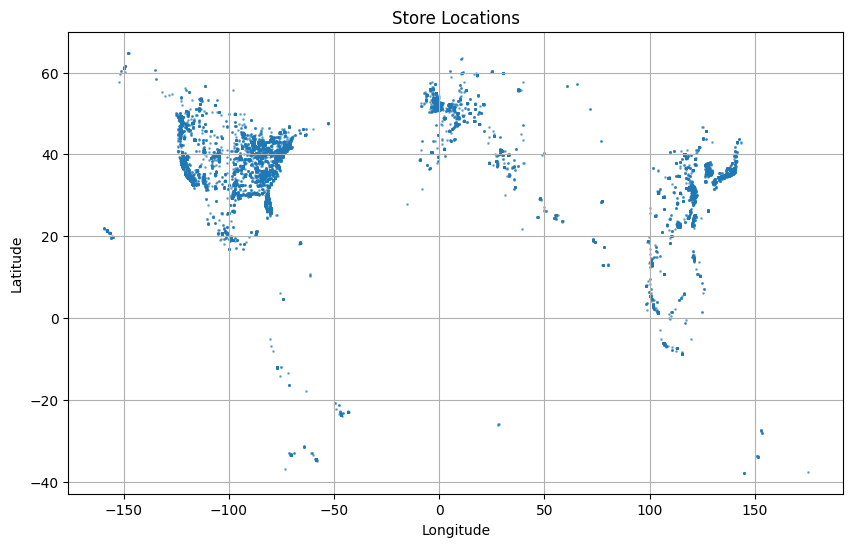

In [26]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(location_pd_df['Longitude'], location_pd_df['Latitude'], alpha=0.5, s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Store Locations')
plt.grid(True)
plt.show()

In [27]:
# Print the schema of the df_cleaned DataFrame
print("Schema of df_cleaned:")
df_cleaned.printSchema()

Schema of df_cleaned:
root
 |-- Store Number: string (nullable = true)
 |-- Store Name: string (nullable = true)
 |-- Ownership Type: string (nullable = true)
 |-- Phone Number: string (nullable = true)
 |-- Address: string (nullable = false)
 |-- Timezone: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)



# Plot points on real Map

In [28]:
# Convert the cleaned Spark DataFrame to a pandas DataFrame
df_cleaned_pd = df_cleaned.toPandas()

# Display the first few rows of the pandas DataFrame to verify
print("First 10 rows of the pandas DataFrame:")
display(df_cleaned_pd.head(10))

First 10 rows of the pandas DataFrame:


,Store Number,Store Name,Ownership Type,Phone Number,Address,Timezone,Postcode,Longitude,Latitude
0,5895-31839,Folsom & Julliard - Sacramento,Company Owned,916-381-3498,"8393 Folsom Blvd., Sacramento, CA, US",GMT-08:00 America/Los_Angeles,958263546,-121.39,38.55
1,22591-221947,Kroger - Suffolk #554,Licensed,757-335-4536,"1017 University Blvd, Suffolk, VA, US",GMT-05:00 America/New_York,23435,-76.09,36.80
2,19536-201611,福州苏宁广场分店,Company Owned,0591-88610511,"台江区, 苏宁广场地上第一层的110室, 南后街101号, 福州市, 35, CN",GMT+08:00 Asia/Beijing,350001,119.29,26.06
3,18156-188186,Mirfield - A62 Leeds Road,Franchise,01924 480 945,"Mirfield, West Yorkshire, Mirfield, ENG, GB",GMT+0:00 Europe/London,WF14 0BY,-1.72,53.69
4,79529-101065,Safeway - Conifer #2792,Licensed,303-838-4375,"Hwy 285 & Light Ln, Conifer, CO, US",GMT-07:00 America/Denver,80433,-105.30,39.53
5,31527-108186,San Chong,Joint Venture,None,"No. 13, Jhengyi N Rd, Sanchong Dist., New Taip...",GMT+08:00 Asia/Taipei,241,121.50,25.06
6,2263-1296,Downtown Arlington Heights,Company Owned,847-392-2051,"33 South Evergreen Avenue, Arlington Heights, ...",GMT-06:00 America/Chicago,600051427,-87.98,42.08
7,12139-15893,Belsize Park - Haverstock Hill,Company Owned,2077947378,"202 Haverstock Hill, Kingsway House, Grd Flr, ...",GMT+0:00 Europe/London,NW3 2AG,-0.16,51.55
8,9926-98924,Hwy 66 & US 411,Company Owned,865-429-2650,"646 Winfield Dunn Parkway, Sevierville, TN, US",GMT-05:00 America/New_York,378765510,-83.57,35.88
9,10312-100471,Charleston & Independence,Company Owned,650-967-9176,"2410 Charleston Avenue, Mountain View, CA, US",GMT-08:00 America/Los_Angeles,940431622,-122.10,37.42


In [29]:
import folium
import pandas as pd


# Pick a center for the map (mean lat/lon of cleaned data)
center_lat = df_cleaned_pd["Latitude"].mean()
center_lon = df_cleaned_pd["Longitude"].mean()

# Create map
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Add points
for _, row in df_cleaned_pd.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=2,
        color="red",
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m

Output hidden; open in https://colab.research.google.com to view.

# Compute distance on cluster

In [30]:
import math

# Reuse the haversine function defined earlier
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of earth in kilometers
    lon1_rad = math.radians(lon1)
    lat1_rad = math.radians(lat1)
    lon2_rad = math.radians(lon2)
    lat2_rad = math.radians(lat2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

def find_nearest_store(input_lon, input_lat, stores_df_pd):
    """
    Finds the nearest store to a given longitude and latitude using a pandas DataFrame.

    Args:
        input_lon (float): The input longitude.
        input_lat (float): The input latitude.
        stores_df_pd (pandas DataFrame): DataFrame with store data including
                                        'Store Number', 'Address',
                                        'Longitude', and 'Latitude'.

    Returns:
        pandas.Series: A Series object containing the nearest store's data,
                       including 'distance'. Returns None if the input DataFrame is empty.
    """
    if stores_df_pd.empty:
        return None

    # Calculate distance from the input point to each store using pandas apply
    stores_df_pd['distance'] = stores_df_pd.apply(
        lambda row: haversine(input_lon, input_lat, row['Longitude'], row['Latitude']),
        axis=1
    )

    # Find the store with the minimum distance
    nearest_store = stores_df_pd.loc[stores_df_pd['distance'].idxmin()]

    return nearest_store


# Prepare the store data in pandas DataFrame, handling missing values
# Assuming df_cleaned_pd already exists and is the pandas DataFrame from previous steps
stores_for_nearest_pd = df_cleaned_pd.dropna(subset=["Longitude", "Latitude", "Address"])


# User input
user_lat = input("Enter Your Lat:") #23.772579586832098
user_lon = input("Enter Your lon:") #90.40679598066906

# Convert input to float
try:
    user_lat = float(user_lat)
    user_lon = float(user_lon)
except ValueError:
    print("Invalid input. Please enter numerical values for latitude and longitude.")
    nearest = None # Set nearest to None to skip the rest of the process
else:
    nearest = find_nearest_store(user_lon, user_lat, stores_for_nearest_pd)


if nearest is not None:
    print(f"The nearest store is:")
    print(f"  Store Number: {nearest['Store Number']}")
    print(f"  Address: {nearest['Address']}")
    print(f"  Distance: {nearest['distance']:.2f} km")

    # Optional: add to your folium map 'm' if 'm' exists from previous cells
    if 'm' in locals() or 'm' in globals():
         folium.Marker([user_lat, user_lon], popup="You").add_to(m)
         folium.Marker([nearest["Latitude"], nearest["Longitude"]],
                       popup=f"Store #{nearest['Store Number']}\n{nearest['Address']}\n{nearest['distance']:.2f} km").add_to(m)
         folium.PolyLine([[user_lat, user_lon], [nearest["Latitude"], nearest["Longitude"]]]).add_to(m)
         display(m) # Display the updated map
    else:
        print("Folium map 'm' not found. Cannot add markers to map.")
else:
    if 'nearest' is not None or stores_for_nearest_pd.empty: # Handle cases where nearest is None due to empty or no store found
         print("Could not find a nearest store.")


Output hidden; open in https://colab.research.google.com to view.

In [38]:
import math
import osmnx as ox
import folium
import pandas as pd
from pyspark.sql import functions as F

def haversine_udf(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

spark_haversine = F.udf(haversine_udf)

# -----------------------------
# STEP 0: Initial Stats
# -----------------------------
total_stores = df_cleaned.count()
print(f"[INFO] Total stores in dataset: {total_stores}")

# -----------------------------
# 1. Find nearest store
# -----------------------------
my_lat = 12.9716
my_lon = 77.5946

df_with_dist = df_cleaned.withColumn(
    "straight_km",
    spark_haversine(F.lit(my_lat), F.lit(my_lon), F.col("Latitude"), F.col("Longitude")).cast("double")
)

nearest_row = df_with_dist.orderBy(F.col("straight_km").asc()).first()
nearest_straight_km = float(nearest_row["straight_km"])
radius_km = nearest_straight_km * 2

print(f"[STEP 1] Nearest store (straight-line): {nearest_row['Store Name']} at {nearest_straight_km:.2f} km")
print(f"[STEP 1] Search radius: {radius_km:.2f} km")

# -----------------------------
# 2. Filter candidates
# -----------------------------
candidates_df = df_with_dist.filter(F.col("straight_km") <= radius_km).toPandas()
print(f"[STEP 2] Candidate stores in radius: {len(candidates_df)}")

# -----------------------------
# 3. Compute road distances
# -----------------------------
results = []
success_count = 0
fail_count = 0

for idx, row in candidates_df.iterrows():
    store_lat = row["Latitude"]
    store_lon = row["Longitude"]

    print(f"    > Routing to: {row['Store Name']} (Straight: {row['straight_km']:.2f} km)")

    mid_lat = (my_lat + store_lat) / 2
    mid_lon = (my_lon + store_lon) / 2
    graph_distance = int(radius_km * 1000)  # meters

    try:
        # Download graph
        G = ox.graph_from_point((mid_lat, mid_lon), dist=graph_distance, network_type="drive")
        print(f"      Road network: {len(G.nodes)} nodes, {len(G.edges)} edges")

        # Find nearest graph nodes
        orig_node = ox.nearest_nodes(G, my_lon, my_lat)
        dest_node = ox.nearest_nodes(G, store_lon, store_lat)

        # Shortest path
        shortest_route = ox.shortest_path(G, orig_node, dest_node, weight="length")

        # Distance in km
        route_length_m = sum(
            data[0].get("length", 0) if isinstance(data, list) else data.get("length", 0)
            for u, v, data in G.subgraph(shortest_route).edges(data=True)
        )
        route_length_km = route_length_m / 1000
        print(f"      Road distance: {route_length_km:.2f} km")

        results.append({
            "Store Name": row["Store Name"],
            "Latitude": store_lat,
            "Longitude": store_lon,
            "Road Distance (km)": route_length_km,
            "Route": shortest_route,
            "Graph": G
        })
        success_count += 1

    except Exception as e:
        print(f"      [ERROR] Failed routing: {e}")
        fail_count += 1

# -----------------------------
# 4. Summary of routing
# -----------------------------
print(f"[STEP 3] Routing complete.")
print(f"    Successful routes: {success_count}")
print(f"    Failed routes: {fail_count}")

# -----------------------------
# 5. Pick shortest by road
# -----------------------------
if results:
    best = min(results, key=lambda x: x["Road Distance (km)"])
    print(f"[STEP 4] Closest store by road: {best['Store Name']} at {best['Road Distance (km)']:.2f} km")

    # Plot
    G = best["Graph"]
    route_latlons = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in best["Route"]]
    route_map = folium.Map(location=[my_lat, my_lon], zoom_start=12)

    folium.Marker([my_lat, my_lon], popup="Origin", icon=folium.Icon(color="green")).add_to(route_map)
    folium.Marker([best["Latitude"], best["Longitude"]], popup=best["Store Name"], icon=folium.Icon(color="purple")).add_to(route_map)
    folium.PolyLine(route_latlons, color="red", weight=4).add_to(route_map)

    display(route_map)
else:
    print("[INFO] No valid routes found in radius.")


[INFO] Total stores in dataset: 23725
[STEP 1] Nearest store (straight-line): Church Street at 1.68 km
[STEP 1] Search radius: 3.36 km
[STEP 2] Candidate stores in radius: 1
    > Routing to: Church Street (Straight: 1.68 km)
      Road network: 9997 nodes, 25235 edges
      Road distance: 3.02 km
[STEP 3] Routing complete.
    Successful routes: 1
    Failed routes: 0
[STEP 4] Closest store by road: Church Street at 3.02 km


In [39]:
import math
import osmnx as ox
import folium
import pandas as pd
from pyspark.sql import functions as F

def haversine_udf(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    return 2 * R * math.asin(math.sqrt(a))

spark_haversine = F.udf(haversine_udf)

# -----------------------------
# STEP 0: Initial Stats
# -----------------------------
total_stores = df_cleaned.count()
print(f"[INFO] Total stores in dataset: {total_stores}")

# -----------------------------
# 1. Find nearest store
# -----------------------------
my_lat = 12.9716
my_lon = 77.5946

df_with_dist = df_cleaned.withColumn(
    "straight_km",
    spark_haversine(F.lit(my_lat), F.lit(my_lon), F.col("Latitude"), F.col("Longitude")).cast("double")
)

nearest_row = df_with_dist.orderBy(F.col("straight_km").asc()).first()
nearest_straight_km = float(nearest_row["straight_km"])
radius_km = nearest_straight_km * 2

print(f"[STEP 1] Nearest store (straight-line): {nearest_row['Store Name']} at {nearest_straight_km:.2f} km")
print(f"[STEP 1] Search radius: {radius_km:.2f} km")

# -----------------------------
# 2. Filter candidates
# -----------------------------
candidates_df = df_with_dist.filter(F.col("straight_km") <= radius_km).toPandas()
print(f"[STEP 2] Candidate stores in radius: {len(candidates_df)}")

# -----------------------------
# 3. Compute road distances
# -----------------------------
results = []
success_count = 0
fail_count = 0

for idx, row in candidates_df.iterrows():
    store_lat = row["Latitude"]
    store_lon = row["Longitude"]

    print(f"    > Routing to: {row['Store Name']} (Straight: {row['straight_km']:.2f} km)")

    mid_lat = (my_lat + store_lat) / 2
    mid_lon = (my_lon + store_lon) / 2
    graph_distance = int(radius_km * 1000)  # meters

    try:
        # Download graph
        G = ox.graph_from_point((mid_lat, mid_lon), dist=graph_distance, network_type="drive")
        print(f"      Road network: {len(G.nodes)} nodes, {len(G.edges)} edges")

        # Find nearest graph nodes
        orig_node = ox.nearest_nodes(G, my_lon, my_lat)
        dest_node = ox.nearest_nodes(G, store_lon, store_lat)

        # Shortest path
        shortest_route = ox.shortest_path(G, orig_node, dest_node, weight="length")

        # Distance in km
        route_length_m = sum(
            data[0].get("length", 0) if isinstance(data, list) else data.get("length", 0)
            for u, v, data in G.subgraph(shortest_route).edges(data=True)
        )
        route_length_km = route_length_m / 1000
        print(f"      Road distance: {route_length_km:.2f} km")

        results.append({
            "Store Name": row["Store Name"],
            "Latitude": store_lat,
            "Longitude": store_lon,
            "Road Distance (km)": route_length_km,
            "Route": shortest_route,
            "Graph": G
        })
        success_count += 1

    except Exception as e:
        print(f"      [ERROR] Failed routing: {e}")
        fail_count += 1

# -----------------------------
# 4. Summary of routing
# -----------------------------
print(f"[STEP 3] Routing complete.")
print(f"    Successful routes: {success_count}")
print(f"    Failed routes: {fail_count}")

# -----------------------------
# 5. Pick shortest by road
# -----------------------------
if results:
    best = min(results, key=lambda x: x["Road Distance (km)"])
    print(f"[STEP 4] Closest store by road: {best['Store Name']} at {best['Road Distance (km)']:.2f} km")

    # Plot
    G = best["Graph"]
    #route_latlons = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in best["Route"]]


import shapely

route_latlons = []
for u, v in zip(best["Route"][:-1], best["Route"][1:]):
    data = G.get_edge_data(u, v)[0] if isinstance(G.get_edge_data(u, v), dict) else list(G.get_edge_data(u, v).values())[0]

    if "geometry" in data:
        # Add all intermediate points from geometry
        coords = list(data["geometry"].coords)
        route_latlons.extend([(lat, lon) for lon, lat in coords])
    else:
        # Just use the start/end node if no geometry
        route_latlons.append((G.nodes[u]['y'], G.nodes[u]['x']))
        route_latlons.append((G.nodes[v]['y'], G.nodes[v]['x']))


    route_map = folium.Map(location=[my_lat, my_lon], zoom_start=12)

    folium.Marker([my_lat, my_lon], popup="Origin", icon=folium.Icon(color="green")).add_to(route_map)
    folium.Marker([best["Latitude"], best["Longitude"]], popup=best["Store Name"], icon=folium.Icon(color="purple")).add_to(route_map)
    folium.PolyLine(route_latlons, color="red", weight=4).add_to(route_map)

    display(route_map)
else:
    print("[INFO] No valid routes found in radius.")


[INFO] Total stores in dataset: 23725
[STEP 1] Nearest store (straight-line): Church Street at 1.68 km
[STEP 1] Search radius: 3.36 km
[STEP 2] Candidate stores in radius: 1
    > Routing to: Church Street (Straight: 1.68 km)
      Road network: 9997 nodes, 25235 edges
      Road distance: 3.02 km
[STEP 3] Routing complete.
    Successful routes: 1
    Failed routes: 0
[STEP 4] Closest store by road: Church Street at 3.02 km


[INFO] No valid routes found in radius.
